In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-data/data.csv


# Problem Description
 - The goal of this challenge is to correctly classify 99 species of plants using extracted attributes, such as margin, shape, and texture. leaves are a useful tool for distinguishing between different plant species. They also offer an enjoyable introduction to using methods that use features from images' characteristics.

 -Try creating a classifier using the available pre-extracted features as a first step.
 - The competition and data link [here](https://www.kaggle.com/competitions/leaf-classification/data)

# Import Libraries

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
from sklearn.preprocessing import StandardScaler
from keras import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import TensorBoard, EarlyStopping
import keras.backend as K
from keras.callbacks import TensorBoard

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# load jupyter_tensorboard
%load_ext tensorboard

# Load Data and Preprocessing

In [4]:
# read the data as a data frame
df = pd.read_csv("/kaggle/input/leaf-data/data.csv", index_col="id")
df.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 1 to 1584
Columns: 193 entries, species to texture64
dtypes: float64(192), object(1)
memory usage: 1.5+ MB


- As we can see there is one feature that are object type, let's show it
- This column will be the target column in our classification problem

In [6]:
df.select_dtypes("object")

,species
id,
1,Acer_Opalus
2,Pterocarya_Stenoptera
3,Quercus_Hartwissiana
5,Tilia_Tomentosa
6,Quercus_Variabilis
...,...
1575,Magnolia_Salicifolia
1578,Acer_Pictum
1581,Alnus_Maximowiczii


## Describe the data

In [7]:
# show some metrics for data statistics
df.describe()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,0.016071,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,0.005859,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,0.015625,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,0.027344,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,0.097656,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


## Check the data for missing values or duplicates and carry out proper correction methods

In [8]:
# check if the data has any missing values
df.isnull().any().any()

False

- As we can see there is no any missing values

In [9]:
# check if there is any duplicated sample
df.duplicated().any()

False

- As we can see there is no any duplication

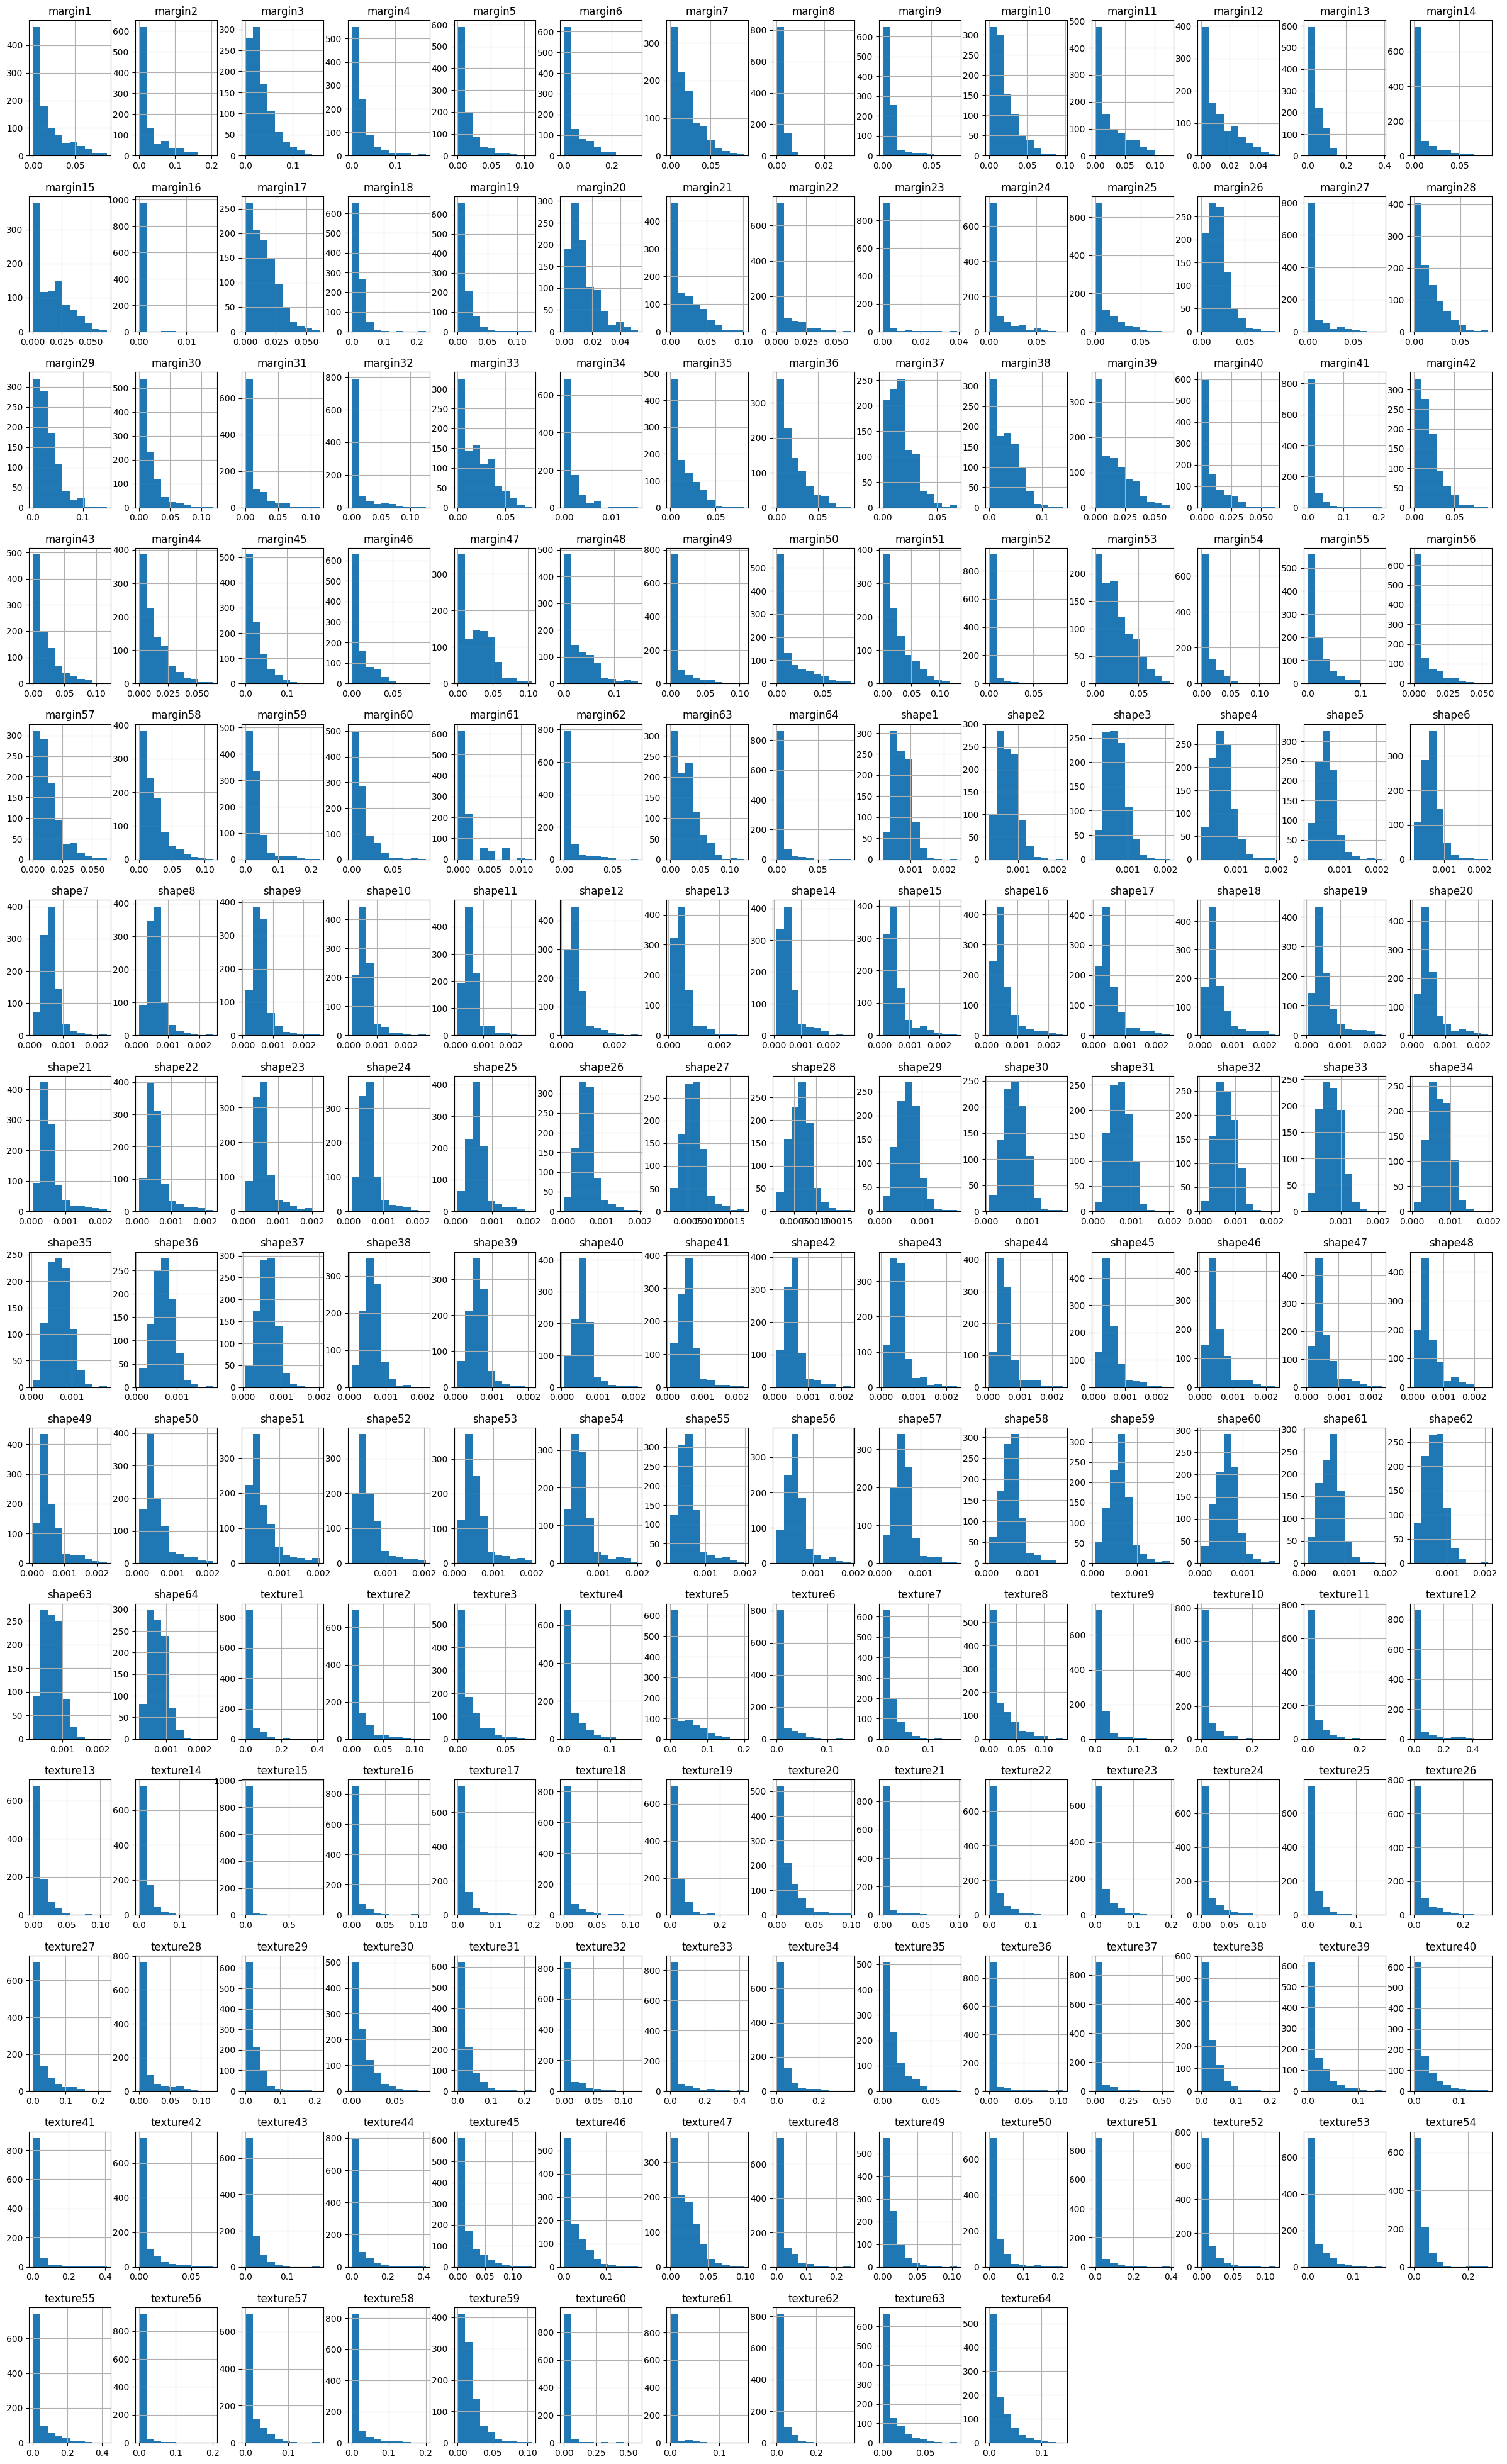

In [10]:
# show the histogram for each feature
df.drop(["species"], axis=1).hist(figsize=(30, 50));

- As we can notice there is no outliers, and most of them are right skewed.

## Carry out required correlation analysis

/tmp/ipykernel_32/2126105641.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


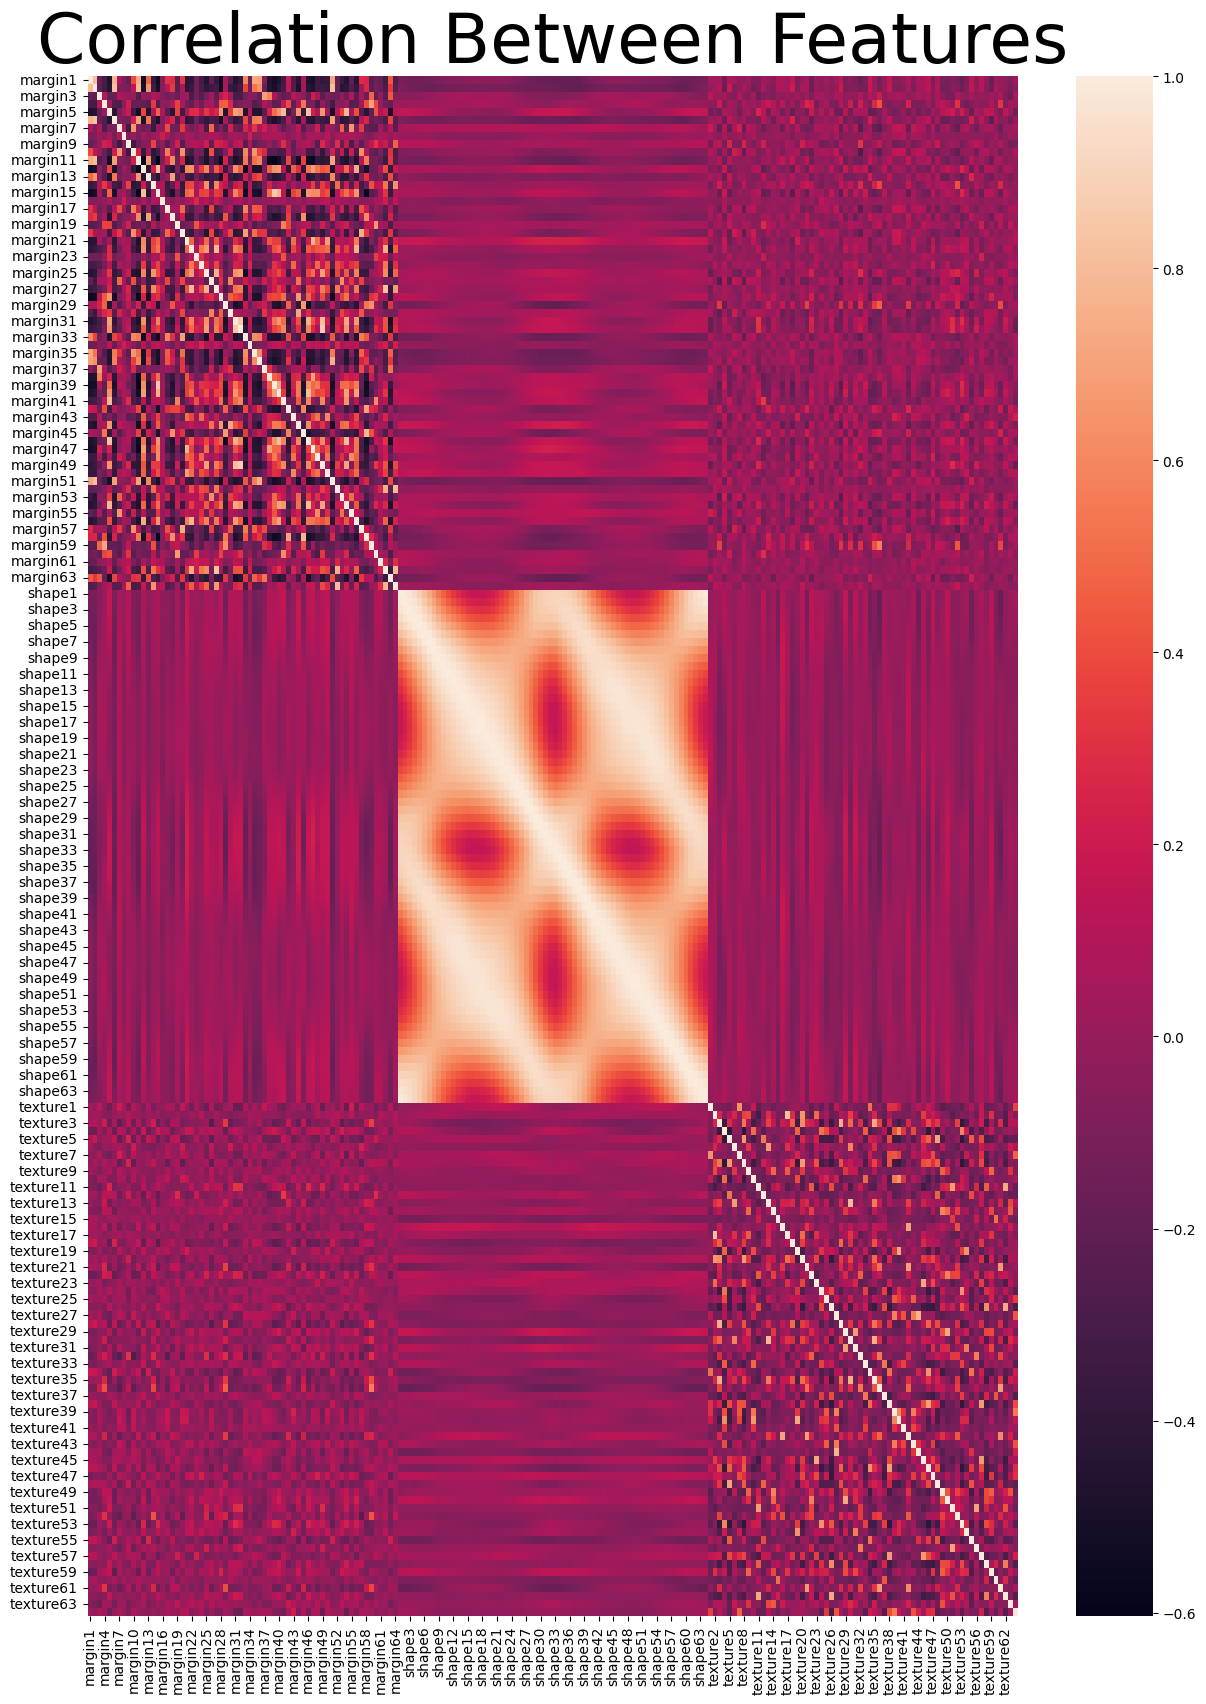

In [11]:
# get the correlation of features
corr = df.corr()
corr
# plot the heatmap of correltion
plt.figure(figsize=(15, 20))
plt.title("Correlation Between Features", fontdict={"fontsize":50})
sns.heatmap(corr)
plt.show();

- As we know there are three sets of features, they are margin, shape, and texture.
- As we can see the features of margin set have a random correlations, where some of them have very high correlation(positive and negative) and others have very low. The texture set features have the same case.
- But shape set features have a lot of high correlations, where most of features in this set have high correlations together(most of them positive ones).
- The features of two sets margin and texture have a little bit weak correlations with shape features. 

# Divide the data into training and testing

In [12]:
# split features and target columns
X = df.drop(["species"], axis=1).values
y = df["species"].values
# split the data into training and testing with .8 for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, stratify=y, random_state=40)

In [13]:
print(f"the shape of training feature is: {X_train.shape}\nthe shape of training target is: {y_train.shape}")
print("##########################################################")
print(f"the shape of testing feature is: {X_test.shape}\nthe shape of testing target is: {y_test.shape}")

the shape of training feature is: (792, 192)
the shape of training target is: (792,)
##########################################################
the shape of testing feature is: (198, 192)
the shape of testing target is: (198,)


# Standardize the data

In [14]:
# get the mean and std for each feature
mean_vector = X_train.mean(axis=0)
std_vector = X_train.std(axis=0)
print("the mean of each feature is: \n", mean_vector)
print("#######################################################################")
print("the std of each feature is: \n", std_vector)

the mean of each feature is: 
 [0.01736106 0.02871979 0.03206874 0.02300837 0.01440917 0.03878882
 0.01909472 0.0011146  0.00716871 0.01847821 0.02411811 0.01205407
 0.04177522 0.00795545 0.01564221 0.00010111 0.01522547 0.02025378
 0.01236972 0.01310216 0.0190503  0.00618978 0.00100368 0.00763243
 0.00873229 0.01869525 0.00558065 0.01568906 0.02820931 0.01649053
 0.01079145 0.0095683  0.0195756  0.00104062 0.01325753 0.01778277
 0.01647331 0.03073457 0.01494432 0.00816261 0.01073966 0.0176496
 0.01877167 0.01280622 0.02452992 0.01011819 0.02505271 0.02694175
 0.00867311 0.01381486 0.02554593 0.00286058 0.02408606 0.01019468
 0.01818721 0.00596535 0.0126558  0.01996277 0.0308603  0.01185185
 0.00136119 0.00503318 0.02549415 0.00442651 0.00074116 0.00071986
 0.00069523 0.00067224 0.00065194 0.00063465 0.00062014 0.00060673
 0.00059343 0.00058134 0.0005723  0.00056397 0.00055719 0.00055251
 0.00054674 0.00054249 0.00054218 0.0005422  0.00054179 0.00054558
 0.00055292 0.0005619  0.0005735

In [15]:
# standardize the training and testing data
X_train = (X_train - mean_vector) / std_vector
X_test = (X_test - mean_vector) / std_vector

# Encode the labels

In [16]:
# get the encoder class
encoder = LabelEncoder()
# train the encoder on training and transform, then transform on test data
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train[:5]

array([27, 35, 50, 78, 75])

# The learnin function

- this function will be used for each experiment that we will explore

In [17]:
def learning_fun(opt, batch, drop_rate, log_name):
    """
    This fun used to build, train and evaluate a deep NN model with some hyperparameters
    Inputs:
      opt: the optimizer to compile the model
      batch: the batch size that will be used for training data
      drop_rate: dropout rate for the hidden layer

    Outputs:
      model: the learned model
      train_loss: the loss on training data
      train_accuracy: the accuracy that the model achieves on training data
      val_loss: the loss on testing data
      val_accuracy: the accuracy that the model achieves on testing data
    """
    # some metadata to build the NN
    no_features = X_train.shape[1] # no. of features that will be feed to the model
    no_classes = len(np.unique(y_train)) # no. classes in target column that will be predected
    
    # intialize a sequential model 
    model = keras.Sequential()
    
    # build the model layers
    model.add(Input(no_features,))
    model.add(Dense(units=128, activation="tanh", name="hidden_layer"))
    model.add(Dropout(drop_rate))
    model.add(Dense(units=no_classes, activation="softmax", name="output_layer"))
    
    # finalize the model hyperparameters with compile
    model.compile(opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    # Define the TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir='./'+log_name)
    # Define the early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    
    # train the model 
    model.fit(X_train, y_train, batch_size=batch, validation_data=(X_test, y_test), verbose=0, epochs=1000, callbacks=[tensorboard_callback, early_stop])
    
    # Evaluate the model on training and testing data
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    val_loss, val_accuracy = model.evaluate(X_test, y_test)

    return model, train_loss, train_accuracy, val_loss, val_accuracy

# Build Models

In [18]:
# import the optimizers that will be used
from keras.optimizers import SGD, Adam, RMSprop

## 1st Experiment:
-  We will explore learning rate.

In [19]:
# the experiment results
exp1_res = []
learn_rate = [1, 0.1, 0.01, 0.001, 0.0001]

for i, lr in enumerate(learn_rate):
    opt = Adam(learning_rate=lr)
    exp1_res.append(learning_fun(opt=opt, batch=32, drop_rate=0.2, log_name=f"experiment_1_v{i+1}"))
    print("################################################################################") # to seperate each exploration
   
    # Clear the Keras session
    K.clear_session()

for i, value in enumerate(exp1_res):
    print(f"When using {learn_rate[i]} learning rate with the model we get:\n")
    print(f"\tOn training\n\t\tWe got loss: {round(value[1], 2)} and accuracy: {round(value[2], 2)}")
    print(f"\tOn testing\n\t\tWe got loss: {round(value[3], 2)} and accuracy: {round(value[4], 2)}")
    print("################################################################################") # to seperate each exploration result

7/7 [==============================] - 0s 3ms/step - loss: 24.6185 - accuracy: 0.7727
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 2.0495 - accuracy: 0.8283
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.9747
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9798
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.0809 - accuracy: 0.9747
################################################################################
When using 1 learning rate with the model we get:

	On training
		We got loss: 9.42 and accuracy: 0.9
	On testing
		We got loss: 24.62 and accuracy: 0.77
###############

In [ ]:
# plot best model results
%tensorboard --logdir /content/experiment_1_v5

### Notes of 1st Experiment:
 - When we started with high learning rate the model converges early(vanishing problem).
 - As we decreasing the learning rate the performace becomes better till we got accuracy on training about (loss=0.0, accuracy=1.0) and on testing about (loss=0.07, accuracy=0.98) (this is very good, lr=0.001).
 - When we decrease the learning rate more it takes a long time to converge.   

## 2nd Experiment:
-  We will explore optimizer.

In [21]:
# the experiment results
exp2_res = []
optimizers = [("SGD",SGD(learning_rate=0.01)), ("Adam",Adam(learning_rate=0.01)), ("RMSprop",RMSprop(learning_rate=0.01))]

for i, opt in enumerate(optimizers):
    exp2_res.append(learning_fun(opt=opt[1], batch=32, drop_rate=0.2, log_name=f"experiment_2_v{i+1}"))
    print("################################################################################") # to seperate each exploration
   
    # Clear the Keras session
    K.clear_session()

for i, value in enumerate(exp2_res):
    print(f"When using {optimizers[i][0]} optimizer with the model we get:\n")
    print(f"\tOn training\n\t\tWe got loss: {round(value[1], 2)} and accuracy: {round(value[2], 2)}")
    print(f"\tOn testing\n\t\tWe got loss: {round(value[3], 2)} and accuracy: {round(value[4], 2)}")
    print("################################################################################") # to seperate each exploration result

7/7 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9798
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.0655 - accuracy: 0.9848
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.0512 - accuracy: 0.9848
################################################################################
When using SGD optimizer with the model we get:

	On training
		We got loss: 0.01 and accuracy: 1.0
	On testing
		We got loss: 0.1 and accuracy: 0.98
################################################################################
When using Adam optimizer with the model we get:

	On training
		We got loss: 0.0 and accuracy: 1.0
	On testing
		We got loss: 0.07 and accuracy: 0.98
################################################################################
When using RMSprop optimizer with the m

In [ ]:
# plot best model results
%tensorboard --logdir /content/experiment_2_v3

### Notes of 2nd Experiment:
 - As we can notice the Adam and RMSprop optimizers achieve best results, where the accuracy on trainig is (loss=0.0, accuracy=1.0) and on testing is (loss=0.05, accuracy=0.98) (the best result we got from this exploration is RMSprop result).
 - SGD optimizer toke long time to finish, but Adam and RMSprop toke short time
 

## 3rd Experiment:
-  We will explore batch size.

In [23]:
# the experiment results
exp3_res = []
batch_size = [32, 64, 128]
opt = Adam(learning_rate=0.01)
for i, batch in enumerate(batch_size):
    exp3_res.append(learning_fun(opt=opt, batch=batch, drop_rate=0.2, log_name=f"experiment_3_v{i+1}"))
    print("################################################################################") # to seperate each exploration
   
    # Clear the Keras session
    K.clear_session()

for i, value in enumerate(exp3_res):
    print(f"When using {batch_size[i]} batch size with the model we get:\n")
    print(f"\tOn training\n\t\tWe got loss: {round(value[1], 2)} and accuracy: {round(value[2], 2)}")
    print(f"\tOn testing\n\t\tWe got loss: {round(value[3], 2)} and accuracy: {round(value[4], 2)}")
    print("################################################################################") # to seperate each exploration result

7/7 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.9798
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.9646
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9747
################################################################################
When using 32 batch size with the model we get:

	On training
		We got loss: 0.0 and accuracy: 1.0
	On testing
		We got loss: 0.06 and accuracy: 0.98
################################################################################
When using 64 batch size with the model we get:

	On training
		We got loss: 0.01 and accuracy: 1.0
	On testing
		We got loss: 0.14 and accuracy: 0.96
################################################################################
When using 128 batch size with the mode

In [ ]:
# plot best model results
%tensorboard --logdir /content/experiment_3_v1

### Notes of 3rd Experiment:
 - As we can see when the batch size is 32, we get a good result, where on training is about (loss=0.0, accuracy=1.0) on testing is about(loss=0.06, accuracy=0.98)
 - As we increase the size of batch the loss increases
 

## 4th Experiment:
-  We will explore dropout rate.

In [26]:
# the experiment results
exp4_res = []
drop_rates = [0.1, 0.5, 0.9]
opt = Adam(learning_rate=0.01)
for i, drop in enumerate(drop_rates):
    exp4_res.append(learning_fun(opt=opt, batch=32, drop_rate=drop, log_name=f"experiment_4_v{i+1}"))
    print("################################################################################") # to seperate each exploration
   
    # Clear the Keras session
    K.clear_session()

for i, value in enumerate(exp4_res):
    print(f"When using {drop_rates[i]} as a dropout rate with the model we get:\n")
    print(f"\tOn training\n\t\tWe got loss: {round(value[1], 2)} and accuracy: {round(value[2], 2)}")
    print(f"\tOn testing\n\t\tWe got loss: {round(value[3], 2)} and accuracy: {round(value[4], 2)}")
    print("################################################################################") # to seperate each exploration result

7/7 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9848
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.2187 - accuracy: 0.9596
################################################################################
7/7 [==============================] - 0s 3ms/step - loss: 0.3688 - accuracy: 0.9091
################################################################################
When using 0.1 as a dropout rate with the model we get:

	On training
		We got loss: 0.0 and accuracy: 1.0
	On testing
		We got loss: 0.07 and accuracy: 0.98
################################################################################
When using 0.5 as a dropout rate with the model we get:

	On training
		We got loss: 0.01 and accuracy: 0.99
	On testing
		We got loss: 0.22 and accuracy: 0.96
################################################################################
When using 0.9 as a dr

In [ ]:
# plot best model results
%tensorboard --logdir /content/experiment_4_v1

### Notes of 4th Experiment:
 - As we can see when increasing the dropout rate the model performace decreases, where the simplicity increases.
 - The best restult we got is when using a bit small dropout rate(0.1), the result is on training about (loss=0.0, accuracy=1.0) and on testing is about(loss=0.07, accuracy=0.98)